In [602]:
import pandas as pd
import sklearn as sk

In [603]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                                  "ahluwaliasaksham/car-insurance-fraud-detection-dataset/versions/1",
                                  "car_insurance_fraud_dataset.csv")
df.head()


,policy_id,policy_state,policy_deductible,policy_annual_premium,insured_age,insured_sex,insured_education_level,insured_occupation,insured_hobbies,incident_date,...,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,police_report_available,claim_amount,total_claim_amount,fraud_reported
0,POL100000,GA,400,1430.78,74,OTHER,High School,Manager,reading,2024-06-13,...,MI,Charlesville,6,1,4,0,Yes,8161.36,11677.60,Y
1,POL100001,PA,300,854.49,74,MALE,College,Lawyer,chess,2025-03-23,...,OH,Joshuaberg,0,3,4,5,No,18561.79,18027.81,N
2,POL100002,MI,400,1247.28,28,OTHER,PhD,Doctor,reading,2025-01-26,...,MI,Reynoldsfurt,14,4,4,1,No,10734.61,10375.59,N
3,POL100003,CA,600,622.42,37,MALE,PhD,Teacher,yachting,2024-06-03,...,NC,Josephchester,22,3,3,5,No,13188.92,14204.34,N
4,POL100004,MI,700,1458.17,31,OTHER,PhD,Sales,reading,2024-05-21,...,NY,Caitlinfort,18,4,2,4,No,21864.69,24038.84,N


Для выполнения лабораторной работы были выбраны метрики F1-score и ROC-AUC, так как исследуемый датасет является несбалансированным. Метрика Accuracy в данном случае неинформативна, так как модель, предсказывающая всем класс ‘0’ (не фрод), может иметь высокую Accuracy, но будет бесполезна. F1-score позволит контролировать баланс между ложными срабатываниями и пропуском мошенников.

In [604]:
TARGET_NAME = "fraud_reported"
df[TARGET_NAME] = df[TARGET_NAME].map({'Y': 1, 'N': 0})

In [605]:
cols_to_drop = ["policy_id"]
df_clean = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

In [606]:
df_clean = df_clean.fillna(0)

In [607]:
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].astype('category').cat.codes
df_clean.head()

,policy_state,policy_deductible,policy_annual_premium,insured_age,insured_sex,insured_education_level,insured_occupation,insured_hobbies,incident_date,incident_type,...,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,police_report_available,claim_amount,total_claim_amount,fraud_reported
0,2,400,1430.78,74,2,1,4,5,217,1,...,4,1470,6,1,4,0,1,8161.36,11677.60,1
1,8,300,854.49,74,1,0,3,1,500,3,...,7,5579,0,3,4,5,0,18561.79,18027.81,0
2,4,400,1247.28,28,2,3,1,5,444,1,...,4,13241,14,4,4,1,0,10734.61,10375.59,0
3,0,600,622.42,37,1,3,6,6,207,1,...,5,5562,22,3,3,5,0,13188.92,14204.34,0
4,4,700,1458.17,31,2,3,5,5,194,2,...,6,1168,18,4,2,4,0,21864.69,24038.84,0


In [608]:
from sklearn.model_selection import train_test_split
X = df_clean.drop(TARGET_NAME, axis=1)
y = df_clean[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [609]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, roc_curve

model = KNeighborsClassifier(n_neighbors=5)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # Вероятности для ROC-AUC
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

F1-score (класс 1): 0.0273
ROC-AUC: 0.5288
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      7968
           1       0.11      0.02      0.03      1032

    accuracy                           0.87      9000
   macro avg       0.50      0.50      0.48      9000
weighted avg       0.80      0.87      0.83      9000



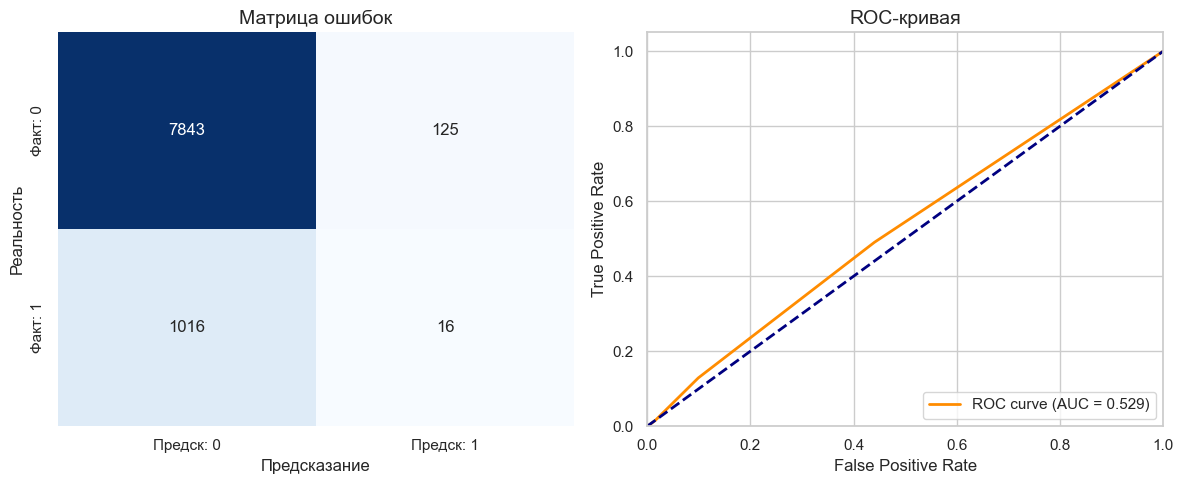

In [610]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
def graphics(y_test, y_pred, y_prob):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=['Предск: 0', 'Предск: 1'],
                yticklabels=['Факт: 0', 'Факт: 1'])
    plt.title("Матрица ошибок", fontsize=14)
    plt.ylabel("Реальность")
    plt.xlabel("Предсказание")

    plt.subplot(1, 2, 2)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая', fontsize=14)
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()
graphics(y_test, y_pred, y_prob)


Из-за отсутствия масштабирования данные получились очень плохие результаты, даже несмотря на хорошую точность (что не является релевантной метрикой в данном случае). Так же из-за того, что один класс доминирует над другим, стоит использовать SMOTE, который добавит нам синтетических данных.

In [611]:
df_improved = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                                  "ahluwaliasaksham/car-insurance-fraud-detection-dataset/versions/1",
                                  "car_insurance_fraud_dataset.csv")
df_improved.head()

,policy_id,policy_state,policy_deductible,policy_annual_premium,insured_age,insured_sex,insured_education_level,insured_occupation,insured_hobbies,incident_date,...,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,police_report_available,claim_amount,total_claim_amount,fraud_reported
0,POL100000,GA,400,1430.78,74,OTHER,High School,Manager,reading,2024-06-13,...,MI,Charlesville,6,1,4,0,Yes,8161.36,11677.60,Y
1,POL100001,PA,300,854.49,74,MALE,College,Lawyer,chess,2025-03-23,...,OH,Joshuaberg,0,3,4,5,No,18561.79,18027.81,N
2,POL100002,MI,400,1247.28,28,OTHER,PhD,Doctor,reading,2025-01-26,...,MI,Reynoldsfurt,14,4,4,1,No,10734.61,10375.59,N
3,POL100003,CA,600,622.42,37,MALE,PhD,Teacher,yachting,2024-06-03,...,NC,Josephchester,22,3,3,5,No,13188.92,14204.34,N
4,POL100004,MI,700,1458.17,31,OTHER,PhD,Sales,reading,2024-05-21,...,NY,Caitlinfort,18,4,2,4,No,21864.69,24038.84,N


In [612]:
df_improved['vehicle_claim_ratio'] = df_improved['claim_amount'] / (df_improved['total_claim_amount'] + 1)

In [613]:
print("Количество уникальных значений:")
for col in df_improved.select_dtypes(include=['object']).columns:
    unique_count = df_improved[col].nunique()
    print(f"{col}: {unique_count}")

Количество уникальных значений:
policy_id: 30000
policy_state: 10
insured_sex: 3
insured_education_level: 4
insured_occupation: 8
insured_hobbies: 7
incident_date: 731
incident_type: 4
collision_type: 4
incident_severity: 3
authorities_contacted: 3
incident_state: 10
incident_city: 17931
police_report_available: 2
fraud_reported: 2


Было выяснено, что почти уникальные столбцы сильно ломают (и очень сильно замедляют KNN), поэтому было принято решение от них отказаться

In [614]:
cols_to_drop = ['policy_id', 'incident_date', 'incident_city']
df_improved = df_improved.drop(columns=[c for c in cols_to_drop if c in df_improved.columns])

In [615]:
df_improved = df_improved.fillna('Unknown')
df_encoded = pd.get_dummies(df_improved, drop_first=True)
df_encoded.head()

,policy_deductible,policy_annual_premium,insured_age,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,claim_amount,total_claim_amount,vehicle_claim_ratio,...,incident_state_GA,incident_state_IL,incident_state_MI,incident_state_NC,incident_state_NY,incident_state_OH,incident_state_PA,incident_state_TX,police_report_available_Yes,fraud_reported_Y
0,400,1430.78,74,6,1,4,0,8161.36,11677.60,0.698830,...,False,False,True,False,False,False,False,False,True,True
1,300,854.49,74,0,3,4,5,18561.79,18027.81,1.029563,...,False,False,False,False,False,True,False,False,False,False
2,400,1247.28,28,14,4,4,1,10734.61,10375.59,1.034503,...,False,False,True,False,False,False,False,False,False,False
3,600,622.42,37,22,3,3,5,13188.92,14204.34,0.928448,...,False,False,False,True,False,False,False,False,False,False
4,700,1458.17,31,18,4,2,4,21864.69,24038.84,0.909519,...,False,False,False,False,True,False,False,False,False,False


Проверим корелляцию с целевой переменной.

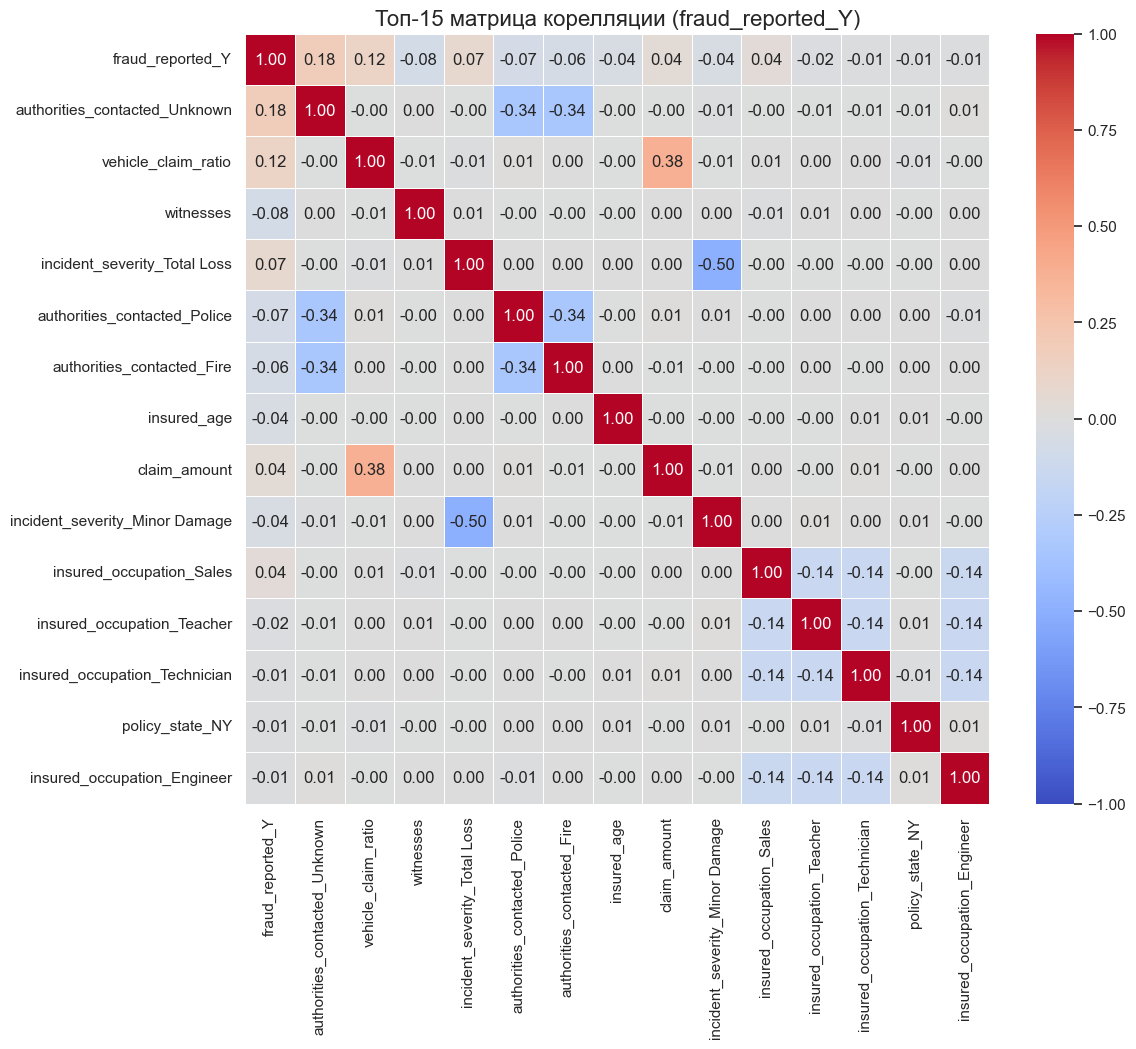

In [616]:
TARGET_NAME_NEW = 'fraud_reported_Y'
corr_with_target = df_encoded.corrwith(df_encoded[TARGET_NAME_NEW]).abs().sort_values(ascending=False)

top_features = corr_with_target.head(15).index.tolist()

plt.figure(figsize=(12, 10))
correlation_matrix = df_encoded[top_features].corr()

sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            vmin=-1, vmax=1,
            linewidths=0.5)

plt.title(f'Топ-15 матрица корелляции ({TARGET_NAME_NEW})', fontsize=16)
plt.show()

Наш новый признак оказался удачным, ура! Дропнем теперь столбцы с шумом, которые имеют слабую корелляцию.

In [617]:
THRESHOLD = 0.02
correlations = df_encoded.corrwith(df_encoded[TARGET_NAME_NEW]).abs()

selected_features = correlations[correlations > THRESHOLD].index.tolist()

if TARGET_NAME_NEW not in selected_features:
    selected_features.append(TARGET_NAME_NEW)

df_final = df_encoded[selected_features]
print(f"Осталось признаков: {df_final.shape[1]}")

Осталось признаков: 11


In [618]:
X_new = df_final.drop("fraud_reported_Y", axis=1)
y_new = df_final["fraud_reported_Y"]

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, test_size=0.3, random_state=42, stratify=y_new
)

In [619]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA


def fit_and_evaluate(knn_params, X_tr, y_tr, X_te, y_te):
    model = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', KNeighborsClassifier(n_neighbors=knn_params, n_jobs=-1))
    ])
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]
    f1 = f1_score(y_te, y_pred)
    roc = roc_auc_score(y_te, y_prob)
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC: {roc:.4f}")
    return model, f1, roc

fit_and_evaluate(5, X_train_new, y_train_new, X_test_new, y_test_new)

F1-score: 0.2824
ROC-AUC: 0.6562


(Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                 ('model', KNeighborsClassifier(n_jobs=-1))]),
 0.28244897959183674,
 0.656170223529778)

In [620]:
from sklearn.model_selection import GridSearchCV
model_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

knn_params = {'model__n_neighbors': [3, 5, 7, 11, 15, 21, 31]}

grid = GridSearchCV(model_pipe, knn_params, cv=3, scoring='f1', verbose=1)
grid.fit(X_train_new, y_train_new)

print(f"Лучшее k: {grid.best_params_['model__n_neighbors']}")

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_new)
y_prob = best_model.predict_proba(X_test_new)[:, 1]

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Лучшее k: 31


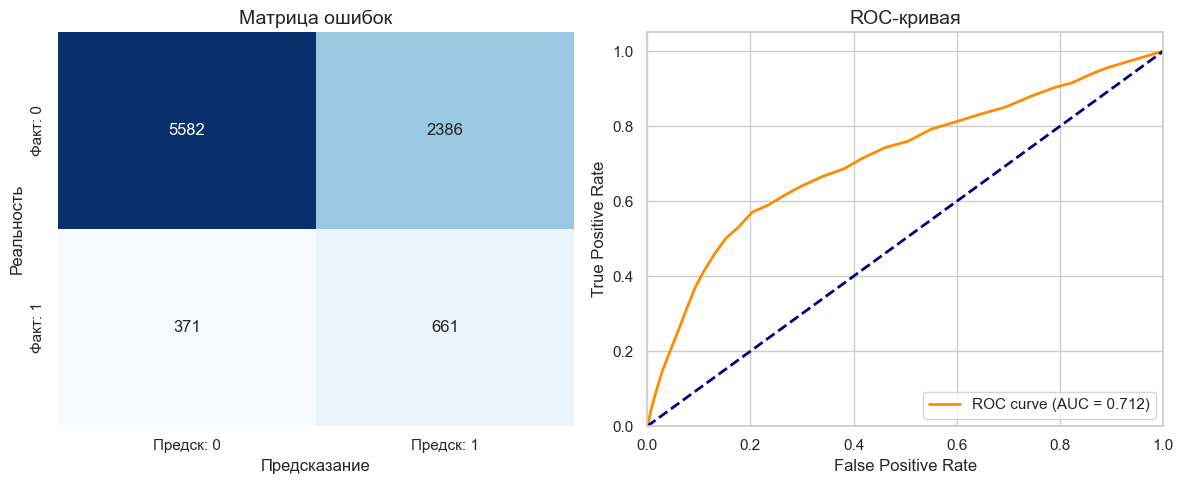

In [621]:
graphics(y_test_new, y_pred, y_prob)

Получилось поймать целых 661 мошенника из 1032 (64%). Это неплохой результат для KNN. Пришлось пожертвовать обвинением многих честных людей, 29% из них были обвинены в мошенничестве. На практике это увеличило бы количество ручных проверок обвинений, но в целом результат норм.

Напишем теперь свою имплементацию

In [622]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from collections import Counter
from scipy.spatial.distance import cdist

class MyKNN(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.Y_train = None

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self

    def predict(self, X):
        X = np.array(X)
        predictions = []

        distances_matrix = cdist(X, self.X_train)

        for distances in distances_matrix:
            k_nearest_idx = np.argsort(distances)[:self.n_neighbors]

            k_nearest_labels = self.y_train[k_nearest_idx]

            most_common = Counter(k_nearest_labels).most_common(1)
            predictions.append(most_common[0][0])

        return np.array(predictions)

    def predict_proba(self, X):
        X = np.array(X)
        distances_matrix = cdist(X, self.X_train, metric='euclidean')
        probabilities = []
        for distances in distances_matrix:
            k_nearest_indices = np.argsort(distances)[:self.n_neighbors]
            k_nearest_labels = self.y_train[k_nearest_indices]
            prob_one = np.sum(k_nearest_labels == 1) / self.n_neighbors
            probabilities.append([1 - prob_one, prob_one])
        return np.array(probabilities)


In [623]:
from sklearn.model_selection import GridSearchCV
my_knn_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', MyKNN(n_neighbors=31))
])

my_knn_pipe.fit(X_train_new, y_train_new)
y_pred_my = my_knn_pipe.predict(X_test_new)
y_prob_my = my_knn_pipe.predict_proba(X_test_new)[:, 1]

f1 = f1_score(y_test_new, y_pred_my)
roc = roc_auc_score(y_test_new, y_prob_my)

print(f"MyKNN Results -> F1: {f1:.4f}, ROC-AUC: {roc:.4f}")

/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.14/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(


MyKNN Results -> F1: 0.3241, ROC-AUC: 0.7123


/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.14/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(


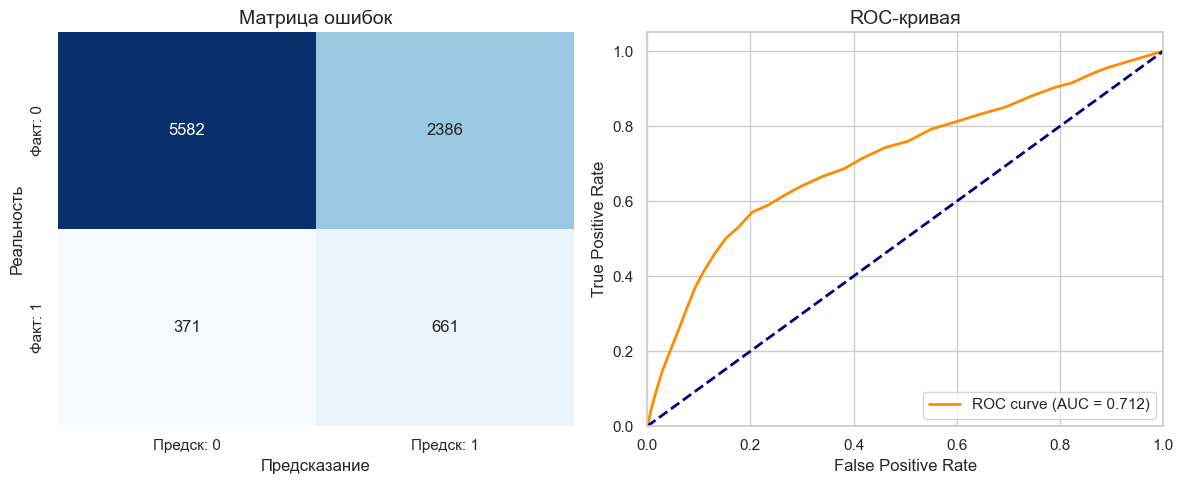

In [624]:
graphics(y_test_new, y_pred, y_prob)

Мой КНН получился совсем не хуже, чем оригинальный. Он выдаёт такие же результаты на тех же данных, только предсказывает чуть дольше из-за отсутствия некоторых оптимизаций.

Перейдем теперь к регрессии.
Задача: предсказать зарплату игрока НХЛ по его статистике.

Будем использовать MAE, так как она очень наглядная, будет легко понять, насколько долларов ошибается модель
Будем использовать accuracy, поскольку очень наглядно.
RMSE использовать тоже попробуем, зарплата может быть нерелевантна качеству игрока, поскольку данные неволатильны.

In [625]:
import kagglehub
from kagglehub import KaggleDatasetAdapter


path = kagglehub.dataset_download(
    "camnugent/predict-nhl-player-salaries/versions/2"
)

df1 = pd.read_csv(path + "/train.csv")

In [697]:
path = kagglehub.dataset_download(
    "camnugent/predict-nhl-player-salaries/versions/2"
)

df2 = pd.read_csv(path + "/test.csv")
salary = pd.read_csv(path + "/test_salaries.csv")
df2['Salary'] = salary['Salary'].values
df2 = df2[df1.columns]
df = pd.concat([df1, df2], ignore_index=True)

Сделаем минимальные телодвижения, чтобы регрессор заработал: закодируем все строковые данные, уберем NaN

In [698]:
df['Born'] = pd.to_datetime(df['Born'], format='%y-%m-%d')
df_clean = df.fillna(0)
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].astype('category').cat.codes
df_clean = df_clean.drop("Born", axis=1)

In [699]:
TARGET_NAME = "Salary"
X = df_clean.drop(TARGET_NAME, axis=1)
y = df_clean[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [700]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
knn = KNeighborsRegressor(n_neighbors=25, weights='distance')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
base_mean_error = mean_absolute_error(y_test, [y_train.mean()]*len(y_test))

print(f"--- Baseline KNN (Raw Data) ---")
print(f"MAE (Ошибка в долларах): {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"Для сравнения: если всегда предсказывать среднее, MAE = {base_mean_error:.3f}")

--- Baseline KNN (Raw Data) ---
MAE (Ошибка в долларах): 1173197.566
RMSE: 1822677.376
R2 Score: 0.399
Для сравнения: если всегда предсказывать среднее, MAE = 1877717.767


Примерно на миллион получилась разница. Уже неплохо, учитывая, что ничего мы не делали

In [1052]:
import kagglehub
from kagglehub import KaggleDatasetAdapter


path = kagglehub.dataset_download(
    "camnugent/predict-nhl-player-salaries/versions/2"
)

df1 = pd.read_csv(path + "/train.csv")
df2 = pd.read_csv(path + "/test.csv")
salary = pd.read_csv(path + "/test_salaries.csv")
df2['Salary'] = salary['Salary'].values
df2 = df2[df1.columns]
df = pd.concat([df1, df2], ignore_index=True)
df.head()

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000.0,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000.0,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000.0,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000.0,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000.0,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


In [1053]:
df['Born'] = pd.to_datetime(df['Born'], format='%y-%m-%d')
reference_date = pd.Timestamp('2016-10-01') # начало сезона
df['Age'] = (reference_date - df['Born']).dt.days / 365.25
df['Experience'] = reference_date.year - df['DftYr']
df['Age_squared'] = df['Age'] ** 2

features_to_drop = ['Born', 'Last Name', 'First Name', 'Nat', 'Pr/St']
df_drop_unneeded = df.drop(features_to_drop, axis=1)
df_drop_unneeded['Match'].value_counts()

Match
0    870
1      4
Name: count, dtype: int64

In [1054]:
has_nan = df_drop_unneeded.isnull().any()

columns_with_nan = has_nan[has_nan].index.tolist()

print("Столбцы, содержащие хотя бы один NaN:")
columns_with_nan

Столбцы, содержащие хотя бы один NaN:


['DftYr',
 'DftRd',
 'Ovrl',
 'TOIX',
 'TOI%',
 'IPP%',
 'SH%',
 'SV%',
 'PDO',
 'F/60',
 'A/60',
 'Diff/60',
 'iCF',
 'iFF',
 'iSF',
 'ixG',
 'iSCF',
 'iRB',
 'iRS',
 'iDS',
 'sDist.1',
 'Pass',
 'iHF.1',
 'iHA',
 'iHDf',
 'iGVA.1',
 'iTKA.1',
 'iBLK.1',
 'BLK%',
 'iFOW.1',
 'iFOL.1',
 '%FOT',
 'iPENT',
 'iPEND',
 'CF',
 'CA',
 'FF',
 'FA',
 'SF',
 'SA',
 'xGF',
 'xGA',
 'SCF',
 'SCA',
 'GF',
 'GA',
 'RBF',
 'RBA',
 'RSF',
 'RSA',
 'FOW',
 'FOL',
 'HF',
 'HA',
 'GVA',
 'TKA',
 'PENT',
 'PEND',
 'OTOI',
 'Pace',
 'GS',
 'GS/G',
 'Experience']

In [1055]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

df_drop_unneeded['DftYr'] = df_drop_unneeded['DftYr'].fillna(df['DftYr'].median())
df_drop_unneeded['DftRd'] = df_drop_unneeded['DftRd'].fillna(df['DftRd'].median())

numeric_cols = df_drop_unneeded.select_dtypes(include=[np.number]).columns
df_numeric = df_drop_unneeded[numeric_cols]
scaler = RobustScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=numeric_cols, index=df_numeric.index)
imputer = KNNImputer(n_neighbors=7)
df_imputed_scaled = pd.DataFrame(imputer.fit_transform(df_scaled), columns=numeric_cols, index=df_numeric.index)

df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed_scaled), columns=numeric_cols, index=df_numeric.index)
df_drop_unneeded[numeric_cols] = df_imputed
df_clean = df_drop_unneeded.copy()

print(f"Осталось пропусков в числах: {df_clean[numeric_cols].isnull().sum().sum()}")
df_clean

Осталось пропусков в числах: 0


,Salary,City,Cntry,Ht,Wt,DftYr,DftRd,Ovrl,Hand,Position,...,PS,OTOI,Grit,DAP,Pace,GS,GS/G,Age,Experience,Age_squared
0,925000.0,Sainte-Marie,CAN,74.0,190.0,2015.0,1.0,18.0,L,D,...,-0.2,40.03,1.0,0.0,175.7,-0.4,-0.38,19.668720,1.0,386.858549
1,2250000.0,Ottawa,CAN,74.0,207.0,2012.0,1.0,15.0,R,D,...,3.2,2850.59,290.0,13.3,112.5,14.1,0.18,22.778919,4.0,518.879130
2,8000000.0,St. Paul,USA,72.0,218.0,2006.0,1.0,7.0,R,RW,...,5.0,2486.75,102.0,6.6,114.8,36.8,0.57,28.459959,10.0,809.969262
3,3500000.0,Ottawa,CAN,77.0,220.0,2010.0,1.0,3.0,R,D,...,0.5,1074.41,130.0,17.5,105.1,5.9,0.20,24.733744,6.0,611.758093
4,1750000.0,Toronto,CAN,76.0,217.0,2012.0,1.0,16.0,R,RW,...,1.3,3459.09,425.0,8.3,99.5,21.8,0.27,22.510609,4.0,506.727525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,632500.0,Kingston,CAN,74.0,219.0,2011.0,2.0,54.0,L,D,...,0.9,858.75,55.0,6.3,105.3,2.6,0.12,19.559206,5.0,382.562540
870,600000.0,Denver,USA,75.0,205.0,2009.0,2.0,44.0,R,C,...,-0.1,588.65,29.0,13.0,99.6,0.4,0.03,21.670089,7.0,469.592756
871,5500000.0,Toronto,CAN,78.0,210.0,2011.0,1.0,9.0,R,D,...,9.5,3133.83,226.0,2.7,113.6,65.1,0.80,19.288159,5.0,372.033070
872,832500.0,Hilton Head Isl.,USA,72.0,181.0,2013.0,1.0,30.0,R,LW/RW,...,4.2,3076.20,223.0,7.9,110.8,43.4,0.57,18.028747,3.0,325.035734


In [1056]:
df_encoded = df_clean.copy()

for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

In [1057]:
THRESHOLD = 0.01
TARGET_NAME = "Salary"

correlations = df_encoded.corrwith(df_encoded[TARGET_NAME]).abs()

selected_features = correlations[correlations > THRESHOLD].index.tolist()
if TARGET_NAME not in selected_features:
    selected_features.append(TARGET_NAME)

df_final = df_encoded[selected_features]
print(f"Осталось признаков: {df_final.shape[1]}")

Осталось признаков: 146


In [1058]:
X = df_final.drop(TARGET_NAME, axis=1)
y = df_final[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [1059]:
from sklearn.preprocessing import RobustScaler

my_knn_pipe = ImbPipeline([
    ('scaler', RobustScaler()),
    ('model', KNeighborsRegressor(n_neighbors=25, weights='distance'))
])
param_grid = {
    'model__n_neighbors': [3, 5, 7, 13, 15, 17, 19, 21, 31, 41, 51, 61, 71],
    'model__metric': ['euclidean', 'manhattan', 'chebyshev']
}

y_train_log = np.log1p(y_train)

grid = GridSearchCV(my_knn_pipe, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train_log)
print(grid.best_params_)

y_pred_log = grid.best_estimator_.predict(X_test)
y_pred = np.expm1(y_pred_log)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
base_mean_error = mean_absolute_error(y_test, [y_train.mean()]*len(y_test))

print(f"--- Baseline KNN (Raw Data) ---")
print(f"MAE (Ошибка в долларах): {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"Для сравнения: если всегда предсказывать среднее, MAE = {base_mean_error:.3f}")

{'model__metric': 'manhattan', 'model__n_neighbors': 13}
--- Baseline KNN (Raw Data) ---
MAE (Ошибка в долларах): 1045526.452
RMSE: 1748612.518
R2 Score: 0.446
Для сравнения: если всегда предсказывать среднее, MAE = 1877717.767


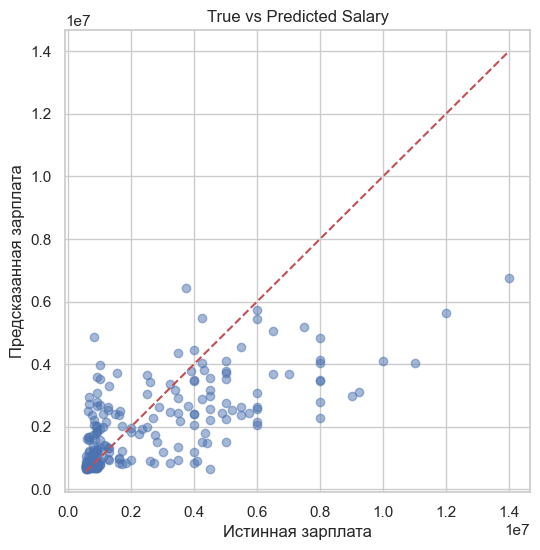

In [1060]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Истинная зарплата")
plt.ylabel("Предсказанная зарплата")
plt.title("True vs Predicted Salary")
plt.grid(True)
plt.show()

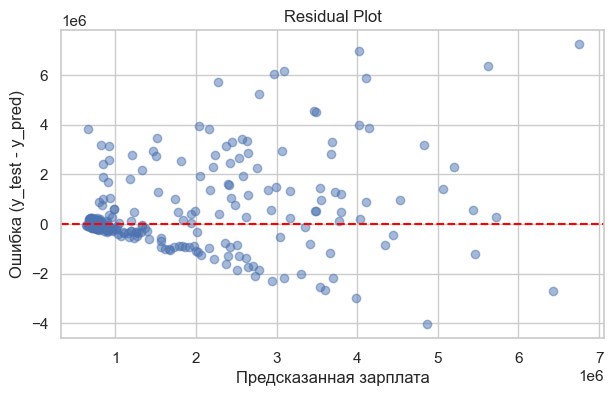

In [1062]:
residuals = y_test - y_pred

plt.figure(figsize=(7,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Предсказанная зарплата")
plt.ylabel("Ошибка (y_test - y_pred)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

По этим графикам хорошо видно, что модель нормально справляется с игроками, с низкой зарплатой, проблемы возникают с игроками, чья зарплата выбивается из общей массы (у топовых хоккеистов). При это выбросы по предсказанной зарплате тоже вполне объясними, потому что это может быть, например, молодой игрок на контракте новичка (первом контракте), у которого хорошая статистика, на уровне топового хоккеиста, но при этом небольшая зарплата, или наоборот, поскольку в НХЛ заключают долгосрочные контракты, иногда могут быть дорогостоящие хоккеисты, которые состарились или деградировали, но имеют завышенную зарплату

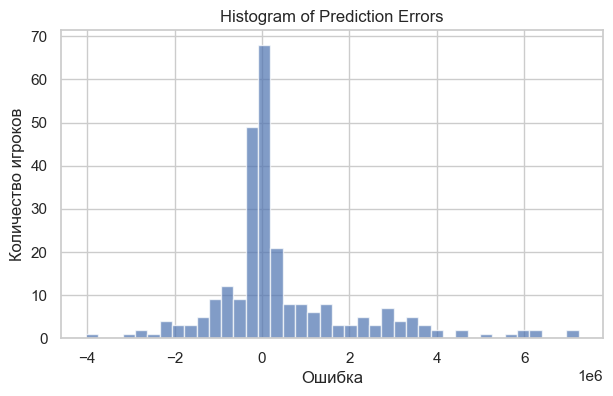

In [1063]:
plt.figure(figsize=(7,4))
plt.hist(residuals, bins=40, alpha=0.7)
plt.title("Histogram of Prediction Errors")
plt.xlabel("Ошибка")
plt.ylabel("Количество игроков")
plt.grid(True)
plt.show()

Видим, что модель довольно точно попадает в большинство игроков, но есть крупные ошибки (занижения и завышения), видимо это связано с тем, что я описывал ранее. Также видим левое смещение, модель склонна занижать зарплату.

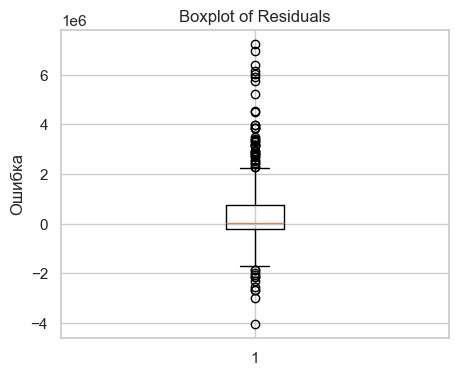

In [1064]:
plt.figure(figsize=(5,4))
plt.boxplot(residuals, vert=True, showfliers=True)
plt.title("Boxplot of Residuals")
plt.ylabel("Ошибка")
plt.grid(True)
plt.show()

In [1068]:
import numpy as np

class MyKNNRegressor:
    def __init__(self, n_neighbors=5, metric="euclidean", weights="uniform"):
        self.k = n_neighbors
        self.metric = metric
        self.weights = weights

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self

    def _distance(self, a, b):
        if self.metric == "euclidean":
            return np.sqrt(np.sum((a - b) ** 2))
        elif self.metric == "manhattan":
            return np.sum(np.abs(a - b))
        elif self.metric == "chebyshev":
            return np.max(np.abs(a - b))
        else:
            raise ValueError("Unknown metric")

    def _get_neighbors(self, x):
        distances = np.array([self._distance(x, x_train) for x_train in self.X_train])
        idx = distances.argsort()[:self.k]
        return idx, distances[idx]

    def predict(self, X):
        X = np.array(X)
        predictions = []
        for x in X:
            idx, dists = self._get_neighbors(x)
            neighbors_y = self.y_train[idx]
            if self.weights == "uniform":
                pred = np.mean(neighbors_y)
            elif self.weights == "distance":
                dists = np.where(dists == 0, 1e-8, dists)
                w = 1 / dists
                pred = np.sum(w * neighbors_y) / np.sum(w)
            else:
                raise ValueError("Unknown weights mode")
            predictions.append(pred)
        return np.array(predictions)

In [1073]:
from sklearn.preprocessing import RobustScaler

my_knn_pipe = ImbPipeline([
    ('scaler', RobustScaler()),
    ('model', MyKNNRegressor(n_neighbors=13, metric="manhattan", weights="distance"))
])

y_train_log = np.log1p(y_train)

my_knn_pipe.fit(X_train, y_train_log)

y_pred_log = my_knn_pipe.predict(X_test)
y_pred = np.expm1(y_pred_log)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
base_mean_error = mean_absolute_error(y_test, [y_train.mean()]*len(y_test))

print(f"--- Baseline KNN (Raw Data) ---")
print(f"MAE (Ошибка в долларах): {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"Для сравнения: если всегда предсказывать среднее, MAE = {base_mean_error:.3f}")

--- Baseline KNN (Raw Data) ---
MAE (Ошибка в долларах): 1045526.452
RMSE: 1748612.518
R2 Score: 0.446
Для сравнения: если всегда предсказывать среднее, MAE = 1877717.767


/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.14/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(


Собственная имплементация показывает те же самые результаты, что и встроенная в sklearn, только обучение идёт несколько медленнее из-за отсутствия оптимизаций.